In [2]:
import torch, os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchvision as vision
import cv2

%matplotlib inline
torch.__version__

'1.7.0+cu101'

In [55]:
!git clone https://github.com/leoxiaobin/deep-high-resolution-net.pytorch
HRNET_DIR =  '/content/deep-high-resolution-net.pytorch'
if os.getcwd()!=HRNET_DIR:
  os.chdir(HRNET_DIR)
!pip install -r requirements.txt

Cloning into 'deep-high-resolution-net.pytorch'...
remote: Enumerating objects: 275, done.
remote: Total 275 (delta 0), reused 0 (delta 0), pack-reused 275
Receiving objects: 100% (275/275), 15.29 MiB | 50.34 MiB/s, done.
Resolving deltas: 100% (127/127), done.
     |████████████████████████████████| 24.9MB 129kB/s 
     |████████████████████████████████| 1.5MB 50.9MB/s 
     |████████████████████████████████| 133kB 59.0MB/s 
  Created wheel for EasyDict: filename=easydict-1.7-cp36-none-any.whl size=6112 sha256=6eedd92d0bbcdaf1885c387a7988936c25fb8ce2c4923f0357d057dad32d0032
  Stored in directory: /root/.cache/pip/wheels/58/40/dd/87bc05b3d56641ccb8f099babf6ff5faed5db5c03c5d837450
Successfully built EasyDict
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: easydict 1.9
    Uninstalling easydict-1.9:
      Successfully uninstalled easydict-1.9
  Found existing installation: opencv-python 

In [56]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
from pycocotools.coco import COCO

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-mdclkx0a
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-mdclkx0a
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=265559 sha256=88d13d876108907c48a6817f5a273a19537602c83f34bb02407431fcf6a1cf89
  Stored in directory: /tmp/pip-ephem-wheel-cache-5pdgpu65/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [57]:
HRNET_DRIVE_DIR = '/content/drive/My Drive/Envisat/HRNet_regression/'


if os.getcwd()!=HRNET_DRIVE_DIR:
  os.chdir(HRNET_DRIVE_DIR)

In [58]:
class Extension:
  def get(filepath):
    return filepath.split('.')[-1]

In [59]:
def compute_bbox(img_size, uv_pt, margin = 5):
        '''


        Parameters
        ----------
        uv_pt : TYPE
            DESCRIPTION.
        margin : TYPE, optional
            DESCRIPTION. The default is 5.

        Returns
        -------
        list
            DESCRIPTION.

        '''
        #margin:percent : default  5% relaxed in w/h
        relax_margin_u= (margin/100)*(max(uv_pt[0])-min(uv_pt[0]))
        relax_margin_v= (margin/100)*(max(uv_pt[1])-min(uv_pt[1]))
        u_max = max(uv_pt[0])+relax_margin_u if max(uv_pt[0])+relax_margin_u <=img_size[0] else img_size[0]
        u_min = min(uv_pt[0])-relax_margin_u if min(uv_pt[0])-relax_margin_u >= 0 else 0
        v_max = max(uv_pt[1])+relax_margin_v if max(uv_pt[1])+relax_margin_v <=img_size[1] else img_size[1]
        v_min = min(uv_pt[1])-relax_margin_v if min(uv_pt[1])-relax_margin_v >= 0 else 0

        return [int(u_min), int(v_min), int(u_max), int(v_max)]

## Original Image and Annotations

Import image

In [87]:
img_path = '/content/drive/MyDrive/Envisat/data/Envisat_inference_test_Jan_2021/image_0.png'
datafile = '/content/drive/MyDrive/Envisat/data/Envisat_inference_test_Jan_2021/data.txt'
coco_available = False # COCO annotations in datafile?
n_kps = 12

img_name= (img_path.split('/')[-1]).split('.')[0]
img = Image.open(img_path,'r')
channels = 3 if  np.array(img).shape[2]==3 else 1
img_size = (img.size[0],img.size[1])
if channels==1:
  img1=np.array(img)
  img1 = np.zeros((gray.shape[0],gray.shape[1],3),dtype='uint8')
  img1[:,:,0] = gray 
  img1[:,:,1] = gray 
  img1[:,:,2] = gray
  img= Image.fromarray(img1)


Compute or import bbox

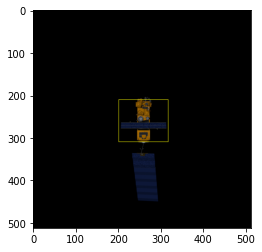

In [88]:
if coco_available:
  cocofile = datafile
  cocofile = '/content/drive/My Drive/Envisat/data/Envisat_Set1/traj_test/test_traj_12pts_150m.json'
  coco = COCO(cocofile)
  annIds = coco.getAnnIds(imgIds = img_id)
  annotations = coco.loadAnns(annIds)
  bbox= {img_name: annotations[0]['bbox']}
  kps= {img_name: annotations[0]['keypoints']}
  coords = kps[img_name] 
  kps_gt = np.zeros((n_kps,2))
  uv_pt = ([],[])
  for k in range(n_kps):
    x = coords[3*k]
    y =coords[3*k+1]
    kps_gt[k,:] = [x,y]
    uv_pt[0].append(x)
    uv_pt[1].append(y)

  xyxy = compute_bbox((512,512),uv_pt)
  xywh = [ xyxy[0],xyxy[1], xyxy[2]-xyxy[0], xyxy[3]-xyxy[1]] 
  bbox = {img_name: xywh} if n_kps==12 else bbox 

elif Extension.get(datafile) == 'txt': #this is tricky but improve it when needed
  with open(datafile,'r') as fp:
    txt_data = fp.read()
  parsed_raw = txt_data.split(' ')
  img_id = parsed_raw[0]
  kps_raw = parsed_raw[7:]
  u_list = []
  v_list = []
  for i in range(int(len(kps_raw)/3)): #take care: id included : change 3 to 2 otherwise
    u = float(kps_raw[3*i+1])
    v = float(kps_raw[3*i+2])
    u_list.append(u)
    v_list.append(v)
  uv_pts = [u_list, v_list]
  kps_gt = [[u_list[j],v_list[j]] for j in range(len(u_list))]
  xyxy = compute_bbox(img_size,uv_pts)
  xywh = [ xyxy[0],xyxy[1], xyxy[2]-xyxy[0], xyxy[3]-xyxy[1]] 
  bbox = {img_name: xywh} if n_kps==12 else bbox 

  img_trial = np.array(img.copy())
  #visualize
  cv2.rectangle(img_trial,(xyxy[0],xyxy[1]),(xyxy[2],xyxy[3]), color=(255,255,0))
  plt.imshow(img_trial)

In [89]:
kps_gt

[[245.590549882, 215.619821516],
 [273.074447875, 215.619923097],
 [273.498464467, 214.617401798],
 [245.255156145, 214.617297188],
 [244.708511127, 304.85968411],
 [245.044188133, 303.358878486],
 [273.878679159, 303.360564815],
 [274.473872262, 304.927236931],
 [312.440450407, 277.423877127],
 [206.368073727, 277.555761113],
 [207.215156666, 264.188291004],
 [312.093932509, 264.188638576]]

In [90]:
"""img_id=10
n_kps = 12
img_path = f'/content/drive/MyDrive/Envisat/data/Lab-real Envisat/image_97_brightness.png'
img = Image.open(img_path,'r')
gray=np.array(img)
img1 = gray
#img1 = np.zeros((gray.shape[0],gray.shape[1],3),dtype='uint8')
#img1[:,:,0] = gray 
#img1[:,:,1] = gray 
#img1[:,:,2] = gray 
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.imshow(img1)
img= Image.fromarray(img1)
bbox = [0,0, img1.shape[0], img1.shape[1]];


img_name = (img_path.split('/')[-1]).split('.')[0]
datafile = '/content/drive/MyDrive/Envisat/data/Envisat_inference_test_Jan_2021/data.txt'
cocofile = None



'''cocofile = '/content/drive/My Drive/Envisat/data/Envisat_Set1/traj_test/test_traj_12pts_150m.json'
coco = COCO(cocofile)
annIds = coco.getAnnIds(imgIds = img_id)
annotations = coco.loadAnns(annIds)
bbox= {img_name: annotations[0]['bbox']}
kps= {img_name: annotations[0]['keypoints']}
coords = kps[img_name] 
kps_gt = np.zeros((n_kps,2))
uv_pt = ([],[])
for k in range(n_kps):
  x = coords[3*k]
  y =coords[3*k+1]
  kps_gt[k,:] = [x,y]
  uv_pt[0].append(x)
  uv_pt[1].append(y)

xyxy = compute_bbox((512,512),uv_pt) 
'''
xywh = bbox
#xywh = [ xyxy[0],xyxy[1], xyxy[2]-xyxy[0], xyxy[3]-xyxy[1]] 
#bbox = {img_name: xywh} if n_kps==12 else bbox
bbox = {img_name: xywh}"""

"img_id=10\nn_kps = 12\nimg_path = f'/content/drive/MyDrive/Envisat/data/Lab-real Envisat/image_97_brightness.png'\nimg = Image.open(img_path,'r')\ngray=np.array(img)\nimg1 = gray\n#img1 = np.zeros((gray.shape[0],gray.shape[1],3),dtype='uint8')\n#img1[:,:,0] = gray \n#img1[:,:,1] = gray \n#img1[:,:,2] = gray \nfig = plt.figure(figsize=(10,10))\nax = fig.gca()\nax.imshow(img1)\nimg= Image.fromarray(img1)\nbbox = [0,0, img1.shape[0], img1.shape[1]];\n\n\nimg_name = (img_path.split('/')[-1]).split('.')[0]\ndatafile = '/content/drive/MyDrive/Envisat/data/Envisat_inference_test_Jan_2021/data.txt'\ncocofile = None\n\n\n\n'''cocofile = '/content/drive/My Drive/Envisat/data/Envisat_Set1/traj_test/test_traj_12pts_150m.json'\ncoco = COCO(cocofile)\nannIds = coco.getAnnIds(imgIds = img_id)\nannotations = coco.loadAnns(annIds)\nbbox= {img_name: annotations[0]['bbox']}\nkps= {img_name: annotations[0]['keypoints']}\ncoords = kps[img_name] \nkps_gt = np.zeros((n_kps,2))\nuv_pt = ([],[])\nfor k in ran

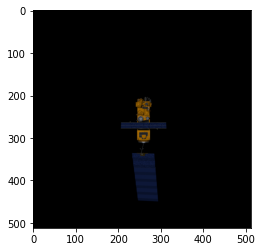

In [91]:
plt.imshow(img)

Image Transforms

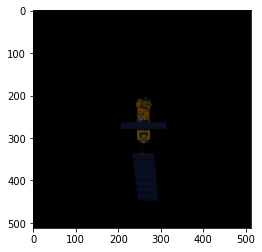

In [92]:
jitter = vision.transforms.ColorJitter(brightness= 0.5,contrast=0.5)#, saturation = 0.1, hue = 0.5)
jitter = jitter(img)
plt.imshow(jitter)

Fake args Namespace Class

In [93]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


# Pose Inference: IPython

In [94]:
'''DO NOT JUDGE THIS CODE. 
   IT WAS WRITTEN AT 3 AM 
   DURING COVID-19 QUARANTINE
'''

from demo.sat_pose_inference import main as infer_kepyoints

cfg_path = '/content/drive/My Drive/Envisat/HRNet_regression/experiments/EXP/EXP6_w32small_256x256_adam_lr1e-3_ENVISAT+IC_NOimagenet.yaml'
#cfg_path = '/content/drive/My Drive/Envisat/HRNet_regression/experiments/coco/hrnet/w32_256x256_adam_lr1e-3_ENVISAT-1_test.yaml'

model_path = 'output/Envisat+IC/envisat_coco_envisat/pose_hrnet/EXP6_w32small_256x256_adam_lr1e-3_ENVISAT+IC_NOimagenet/model_best.pth'
#model_path = 'output/Envisat_Set1/coco/pose_hrnet/w32_256x256_adam_lr1e-3_ENVISAT-1/model_best.pth'


''' Name you test data_set here. This helps segment tests in /output/sat_pose_inferences by folder of data_name'''
data_name = 'beta_test'

img_bgr = np.array(jitter)
img_in0 =img_bgr[:, :, [2, 1, 0]]
img_in1 = img_in0.copy();
img_in = cv2.GaussianBlur(img_in1,(3,3),2)
bbox_in = bbox


args = Namespace(
    cfg= cfg_path,
    data_name = data_name,
    logDir = 'log/',
    outputDir = 'output/', 
    modelDir = '',
    dataDir = '',
    prevModelDir = '',
    writeBoxFrames = False,
    opts = ['TEST.MODEL_FILE', model_path],)



#str_dir = f'/content/drive/My\ Drive/Envisat/data/Envisat_Set1/traj_test/test_traj_150m/0-999/image_{img_id}.jpg'
kps_pred, maxvals = infer_kepyoints(image= img_in, bbox= bbox_in, args = args)
print(kps_pred)
print(maxvals)

=> loading model from output/Envisat+IC/envisat_coco_envisat/pose_hrnet/EXP6_w32small_256x256_adam_lr1e-3_ENVISAT+IC_NOimagenet/model_best.pth
{'image_0': 0}
image_0
[[201, 210, 116, 99]]
2
[[201, 210, 116, 99]]
inference time: 0.011887311935424805 s
0, [272, 215]
1, [270, 215]
2, [247, 214]
3, [244, 215]
4, [206, 263]
5, [311, 263]
6, [311, 278]
7, [207, 278]
8, [245, 301]
9, [245, 305]
10, [272, 300]
11, [273, 305]
output/sat_pose_inferences/envisat_coco_envisat/beta_test/poses/image_0_pose.jpg
[[[272.02734 215.88672]
  [270.89453 215.88672]
  [247.10547 214.7539 ]
  [244.83984 215.88672]
  [206.32422 263.46484]
  [311.67578 263.46484]
  [311.67578 278.1914 ]
  [207.45703 278.1914 ]
  [245.97266 301.98047]
  [245.97266 305.3789 ]
  [272.02734 300.84766]
  [273.16016 305.3789 ]]]
[[[0.9536944 ]
  [0.92524505]
  [0.85155034]
  [0.9158264 ]
  [0.9598065 ]
  [0.87176704]
  [0.9262904 ]
  [0.98752373]
  [0.94279146]
  [0.8538541 ]
  [0.7876201 ]
  [0.905343  ]]]


Show Result

In [95]:
bbox_in

{'image_0': [201, 210, 116, 99]}

In [96]:
error = kps_gt-kps_pred[0,:]
dr_error = np.sqrt( error[:,0]**2 + error[:,1]**2 )
mean_dr = np.mean(dr_error)
median_dr = np.median(dr_error)
print(f" Mean Pixel Error: {mean_dr} px \n Median Pixel Error: {median_dr} px \n Max Pixel Error: {np.max(dr_error)} px in keypoint number {np.argmax(dr_error)}")

 Mean Pixel Error: 46.53674826935457 px 
 Median Pixel Error: 52.42672539298036 px 
 Max Pixel Error: 77.66146540483648 px in keypoint number 5


In [97]:
'''from google.colab.patches import cv2_imshow
cv2_imshow(img_in)'''

'from google.colab.patches import cv2_imshow\ncv2_imshow(img_in)'

In [98]:

#output = f'output/sat_pose_inferences/envisat_coco_envisat/beta_test/poses/image_{img_id}_pose.jpg'
output = f'output/sat_pose_inferences/envisat_coco/beta_test/poses/image_{img_id}_pose.jpg'

box = [int(coord) for coord in bbox[list(bbox)[0]]]
img_out = Image.open(output)

x1 = box [0] 
y1 = box[1]
w = box[2]
h = box[3]
x2= box[2]+box[0]
y2 = box[3]+box[1]

cv2.rectangle(np.array(img),(x1,y1),(x2,y2), color = (255,255,0))

img_crop = img_out.crop((x1,y1,x2,y2))
fig = plt.figure(figsize=(20,20))
ax = fig.gca()

print(np.array(img_crop).shape)
ax.imshow(np.asarray(img_crop))

#ax.imshow(img_out)

FileNotFoundError: ignored

In [ ]:
fig1 = plt.figure(figsize=(10,10))
ax = fig.gca()
ax2.imshow(img_out)

# Pose Inference: CLI

In [ ]:
'''DO NOT JUDGE THIS CODE. 
   IT WAS WRITTEN AT 3 AM 
   DURING COVID-19 QUARANTINE
'''


str_dir = f'/content/drive/My\ Drive/Envisat/data/Envisat_Set1/traj_test/test_traj_150m/0-999/image_{img_id}.jpg'
with torch.cuda.device(0):
  !python demo/sat_pose_inference_cmd.py --cfg experiments/coco/hrnet/w32_512x512_adam_lr1e-3_ENVISAT-1_traj_test.yaml \
      --data_name beta_test \
      --data_type image \
      --data_path $str_dir \
      --bbox demo/temp.json \
      TEST.MODEL_FILE output/Envisat_1/coco/pose_hrnet/w32_256x256_adam_lr1e-3_ENVISAT-1/model_best.pth \


output = f'output/sat_pose_inferences/coco/beta_test/poses/image_{img_id}_pose.jpg'
box = bbox[list(bbox)[0]]
img = Image.open(output)

bbox = (box[0],box[1],box[2]+box[0],box[3]+box[1])
cv2.rectangle(np.array(img),(bbox[0],bbox[1], bbox[2], bbox[3]))

img_crop = img.crop(bbox)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.imshow(img)
#ax.imshow(np.asarray(img_crop))
fig1 = plt.figure(figsize=(10,10))
ax1 = fig.gca()
ax1.imshow(img)
ax1.imshow(img_crop)

In [ ]:
os.getcwd()

In [ ]:
img

In [ ]:
print(bbox)